In [220]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import pymorphy3
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\royti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Предобработка

## 1.1 Парсинг

In [221]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import json
import time

def parse_news(url):
    articles = []
    session = requests.Session()
    page_number = 1
    while len(articles) < 250:
        # Формируем URL для каждой страницы с новостями
        page_url = f"{url}/?page={page_number}"
        response = session.get(page_url)
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Парсим статьи с текущей страницы
        page_articles = parse_articles_from_soup(soup)
        articles.extend(page_articles)
        
        # Увеличиваем номер страницы для следующего запроса
        page_number += 1
        
        # Если больше нет кнопки "Показать еще", выходим из цикла
        if not soup.find('button', class_='page__btn page__toggle page__btn_smm_align-self-end page__btn_min-width-230'):
            break
        
        # Ждем немного времени перед следующим запросом
        time.sleep(2)  # Можно изменить время ожидания в зависимости от скорости загрузки страницы
    
    return articles

def parse_articles_from_soup(soup):
    articles = []
    for item in soup.find_all('div', class_='item-card item-card__list item-card_animated-fadeInDow loadmore_item'):
        title_tag = item.find('h2', class_='page__title-h2 page__title-h2_text-left')
        theme_tag = item.find('div', class_='main-annonce__heading-title')
            description_tag = item.find('div', class_='main-annonce__description page__text page_text-left page__text_padding-top-10 page__text_overflow')
        
        if title_tag and date_tag and description_tag and theme_tag:
            title = title_tag.text.strip()
            theme = theme_tag.text.strip()
            description = description_tag.text.strip()
            
            articles.append({
                'title': title, 
                'theme': theme,
                'description': description
            })
    
    return articles

# URL страницы с новостями
url = 'https://sectormedia.ru/news/neft-i-gaz/'

# Парсинг новостей
news_data = parse_news(url)

# Преобразование данных в DataFrame для удобства работы
df = pd.DataFrame(news_data)

# Отображение первых строк DataFrame
str_with_nan = df[df['description'] != '']
df = str_with_nan
df

,title,theme,description
0,В России разработали новый тип электрогенерато...,ВИЭ,Его отличительной чертой является тесная связь...
1,Доходы России от нефти и газа увеличатся на 50%,Экономика и рынки/Нефть и Газ,В июне они вырастут примерно до 814 миллиардов...
2,Определена тема форума TNF 2024 – ключевой пло...,События/Нефть и Газ,Главной темой Промышленно-энергетического фору...
3,«Роснефть» создала технологию для разработки с...,Наука/Нефть и Газ,Она позволяет с высокой точностью определять н...
4,Искусственный интеллект и химия: российский ст...,IT,"Как понять, получите ли вы пользу от участия в..."
...,...,...,...
247,Производство бензина в России отстает от плана,Нефтепереработка,В июне выпуск топлива отстал более чем на 7% о...
248,"Россия намерена контактировать с КНР, Индией и...",События/Нефть и Газ,Использование этой трассы существенно сократит...
249,XIV межрегиональная специализированная выставк...,События/Нефть и Газ,Благодаря разнообразию экспозиций и организаци...
250,Газовый форум соберет в городе на Неве лучших ...,События/Нефть и Газ,С 8 по 11 октября 2024 года в Санкт-Петербурге...


## 1.2 Текст приведён к нижнему регистру

In [222]:
df = df.map(lambda x: x.lower() if isinstance(x, str) else x)
df

,title,theme,description
0,в россии разработали новый тип электрогенерато...,виэ,его отличительной чертой является тесная связь...
1,доходы россии от нефти и газа увеличатся на 50%,экономика и рынки/нефть и газ,в июне они вырастут примерно до 814 миллиардов...
2,определена тема форума tnf 2024 – ключевой пло...,события/нефть и газ,главной темой промышленно-энергетического фору...
3,«роснефть» создала технологию для разработки с...,наука/нефть и газ,она позволяет с высокой точностью определять н...
4,искусственный интеллект и химия: российский ст...,it,"как понять, получите ли вы пользу от участия в..."
...,...,...,...
247,производство бензина в россии отстает от плана,нефтепереработка,в июне выпуск топлива отстал более чем на 7% о...
248,"россия намерена контактировать с кнр, индией и...",события/нефть и газ,использование этой трассы существенно сократит...
249,xiv межрегиональная специализированная выставк...,события/нефть и газ,благодаря разнообразию экспозиций и организаци...
250,газовый форум соберет в городе на неве лучших ...,события/нефть и газ,с 8 по 11 октября 2024 года в санкт-петербурге...


## 1.3 Удаление стоп-слов

In [223]:
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))

def remove_stopwords_and_punctuation(text):
    if isinstance(text, str):  # Проверяем, является ли text строкой
    # Разбиваем текст на слова
        tokens = text.split()
        # Удаляем стоп-слова
        filtered_tokens = [word for word in tokens if word.lower() not in stop_words]
        return ' '.join(filtered_tokens)
    else:
        return text  # Возвращаем исходное значение, если text не является строкой

# Применение функции к каждому элементу DataFrame
df = df.applymap(remove_stopwords_and_punctuation)
df

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\royti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,title,theme,description
0,россии разработали новый тип электрогенератора...,виэ,отличительной чертой является тесная связь маг...
1,доходы россии нефти газа увеличатся 50%,экономика рынки/нефть газ,июне вырастут примерно 814 миллиардов рублей (...
2,определена тема форума tnf 2024 – ключевой пло...,события/нефть газ,главной темой промышленно-энергетического фору...
3,«роснефть» создала технологию разработки сложн...,наука/нефть газ,позволяет высокой точностью определять нефтена...
4,искусственный интеллект химия: российский стар...,it,"понять, получите пользу участия ином проекте? ..."
...,...,...,...
247,производство бензина россии отстает плана,нефтепереработка,июне выпуск топлива отстал 7% планов министерс...
248,"россия намерена контактировать кнр, индией стр...",события/нефть газ,использование трассы существенно сократит врем...
249,xiv межрегиональная специализированная выставк...,события/нефть газ,благодаря разнообразию экспозиций организации ...
250,газовый форум соберет городе неве лучших экспе...,события/нефть газ,8 11 октября 2024 года санкт-петербурге конгре...


## 1.4 Проведена лемматизация

In [224]:
import pymorphy3
# Инициализация pymorphy3
morph = pymorphy3.MorphAnalyzer()

def lemmatize_text(text):
    # Токенизация текста
    tokens = word_tokenize(text)
    
    # Инициализация анализатора морфологии
    morph_analyzer = morph
    
    # Лемматизация токенов
    lemmatized_tokens = [morph_analyzer.parse(word)[0].normal_form for word in tokens if word.isalnum()]
    
    # Соединение лемматизированных токенов в строку
    lemmatized_text = ' '.join(lemmatized_tokens)
    
    return lemmatized_text


df = df.map(lemmatize_text)
df

,title,theme,description
0,россия разработать новый тип электрогенератор ...,виэ,отличительный черта являться тесный связь магн...
1,доход россия нефть газ увеличиться 50,экономика газ,июнь вырасти примерно 814 миллиард рубль милли...
2,определить тема форум tnf 2024 ключевой площад...,газ,главный тема форум tnf 2024 технологический ус...
3,роснефть создать технология разработка сложный...,газ,позволять высокий точность определять нефтенас...
4,искусственный интеллект химия российский старт...,it,понять получить польза участие иной проект рас...
...,...,...,...
247,производство бензин россия отставать план,нефтепереработка,июнь выпуск топливо отстать 7 план министерств...
248,россия намерить контактировать кнр индия стран...,газ,использование трасса существенно сократить вре...
249,xiv межрегиональный специализировать выставка ...,газ,благодаря разнообразие экспозиция организация ...
250,газовый форум собрать город нева хороший экспе...,газ,8 11 октябрь 2024 год центр экспофорум состоят...


# 2. Построение и отбор признаков

## 2.1 Созданы числовые признаки на основе текстовых данных - количество слов, символов

In [225]:
df['title_word_count'] = df['title'].apply(lambda x: len(x.split()))
df['title_char_count'] = df['title'].apply(lambda x: len(x))

df['theme_word_count'] = df['theme'].apply(lambda x: len(x.split()))
df['theme_char_count'] = df['theme'].apply(lambda x: len(x))

df['description_word_count'] = df['description'].apply(lambda x: len(x.split()))
df['description_char_count'] = df['description'].apply(lambda x: len(x))

df

,title,theme,description,title_word_count,title_char_count,theme_word_count,theme_char_count,description_word_count,description_char_count
0,россия разработать новый тип электрогенератор ...,виэ,отличительный черта являться тесный связь магн...,7,69,1,3,9,85
1,доход россия нефть газ увеличиться 50,экономика газ,июнь вырасти примерно 814 миллиард рубль милли...,6,37,2,13,8,56
2,определить тема форум tnf 2024 ключевой площад...,газ,главный тема форум tnf 2024 технологический ус...,9,76,1,3,9,75
3,роснефть создать технология разработка сложный...,газ,позволять высокий точность определять нефтенас...,6,52,1,3,7,66
4,искусственный интеллект химия российский старт...,it,понять получить польза участие иной проект рас...,7,62,1,2,20,156
...,...,...,...,...,...,...,...,...,...
247,производство бензин россия отставать план,нефтепереработка,июнь выпуск топливо отстать 7 план министерств...,5,41,1,16,8,58
248,россия намерить контактировать кнр индия стран...,газ,использование трасса существенно сократить вре...,9,74,1,3,8,68
249,xiv межрегиональный специализировать выставка ...,газ,благодаря разнообразие экспозиция организация ...,11,92,1,3,35,341
250,газовый форум собрать город нева хороший экспе...,газ,8 11 октябрь 2024 год центр экспофорум состоят...,8,56,1,3,19,139


## 2.2 Созданы числовые признаки на основе текстовых данных - заспамленность

In [226]:
# Функция для вычисления признака заспамленности
def calculate_spam_feature(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token.isalnum() and token not in stop_words]

    # Вычисление признака заспамленности
    word_count = len(filtered_tokens)
    char_count = sum(len(word) for word in filtered_tokens)
    if word_count > 0:
        spam_score = char_count / word_count
    else:
        spam_score = 0.0  # если нет слов, заспамленность равна 0
    
    return spam_score

# Применение функций к данным
df['title_spam_score'] = df['title'].apply(calculate_spam_feature)
df['theme_spam_score'] = df['theme'].apply(calculate_spam_feature)
df['description_spam_score'] = df['description'].apply(calculate_spam_feature)

# Вывод результата
df

,title,theme,description,title_word_count,title_char_count,theme_word_count,theme_char_count,description_word_count,description_char_count,title_spam_score,theme_spam_score,description_spam_score
0,россия разработать новый тип электрогенератор ...,виэ,отличительный черта являться тесный связь магн...,7,69,1,3,9,85,9.000000,3.0,8.555556
1,доход россия нефть газ увеличиться 50,экономика газ,июнь вырасти примерно 814 миллиард рубль милли...,6,37,2,13,8,56,5.333333,6.0,6.125000
2,определить тема форум tnf 2024 ключевой площад...,газ,главный тема форум tnf 2024 технологический ус...,9,76,1,3,9,75,7.555556,3.0,7.444444
3,роснефть создать технология разработка сложный...,газ,позволять высокий точность определять нефтенас...,6,52,1,3,7,66,7.833333,3.0,8.571429
4,искусственный интеллект химия российский старт...,it,понять получить польза участие иной проект рас...,7,62,1,2,20,156,8.000000,2.0,7.333333
...,...,...,...,...,...,...,...,...,...,...,...,...
247,производство бензин россия отставать план,нефтепереработка,июнь выпуск топливо отстать 7 план министерств...,5,41,1,16,8,58,7.400000,16.0,6.375000
248,россия намерить контактировать кнр индия стран...,газ,использование трасса существенно сократить вре...,9,74,1,3,8,68,7.333333,3.0,7.625000
249,xiv межрегиональный специализировать выставка ...,газ,благодаря разнообразие экспозиция организация ...,11,92,1,3,35,341,7.454545,3.0,8.771429
250,газовый форум собрать город нева хороший экспе...,газ,8 11 октябрь 2024 год центр экспофорум состоят...,8,56,1,3,19,139,6.125000,3.0,6.500000


## 2.3 Созданы числовые признаки на основе текстовых данных средняя длина слов/предложений

In [227]:
# Функция для вычисления средней длины слов
def avg_word_length(text):
    words = text.split()
    return sum(len(word) for word in words) / len(words)

# Функция для вычисления средней длины предложений
def avg_sentence_length(text):
    sentences = text.split('. ')
    return sum(len(sentence.split()) for sentence in sentences) / len(sentences)

df['title_avg_word_length'] = df['title'].apply(avg_word_length)
df['title_avg_sentence_length'] = df['title'].apply(avg_sentence_length)

df['theme_avg_word_length'] = df['theme'].apply(avg_word_length)
df['theme_avg_sentence_length'] = df['theme'].apply(avg_sentence_length)

df['description_avg_word_length'] = df['description'].apply(avg_word_length)
df['description_avg_sentence_length'] = df['description'].apply(avg_sentence_length)

df

,title,theme,description,title_word_count,title_char_count,theme_word_count,theme_char_count,description_word_count,description_char_count,title_spam_score,theme_spam_score,description_spam_score,title_avg_word_length,title_avg_sentence_length,theme_avg_word_length,theme_avg_sentence_length,description_avg_word_length,description_avg_sentence_length
0,россия разработать новый тип электрогенератор ...,виэ,отличительный черта являться тесный связь магн...,7,69,1,3,9,85,9.000000,3.0,8.555556,9.000000,7.0,3.0,1.0,8.555556,9.0
1,доход россия нефть газ увеличиться 50,экономика газ,июнь вырасти примерно 814 миллиард рубль милли...,6,37,2,13,8,56,5.333333,6.0,6.125000,5.333333,6.0,6.0,2.0,6.125000,8.0
2,определить тема форум tnf 2024 ключевой площад...,газ,главный тема форум tnf 2024 технологический ус...,9,76,1,3,9,75,7.555556,3.0,7.444444,7.555556,9.0,3.0,1.0,7.444444,9.0
3,роснефть создать технология разработка сложный...,газ,позволять высокий точность определять нефтенас...,6,52,1,3,7,66,7.833333,3.0,8.571429,7.833333,6.0,3.0,1.0,8.571429,7.0
4,искусственный интеллект химия российский старт...,it,понять получить польза участие иной проект рас...,7,62,1,2,20,156,8.000000,2.0,7.333333,8.000000,7.0,2.0,1.0,6.850000,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247,производство бензин россия отставать план,нефтепереработка,июнь выпуск топливо отстать 7 план министерств...,5,41,1,16,8,58,7.400000,16.0,6.375000,7.400000,5.0,16.0,1.0,6.375000,8.0
248,россия намерить контактировать кнр индия стран...,газ,использование трасса существенно сократить вре...,9,74,1,3,8,68,7.333333,3.0,7.625000,7.333333,9.0,3.0,1.0,7.625000,8.0
249,xiv межрегиональный специализировать выставка ...,газ,благодаря разнообразие экспозиция организация ...,11,92,1,3,35,341,7.454545,3.0,8.771429,7.454545,11.0,3.0,1.0,8.771429,35.0
250,газовый форум собрать город нева хороший экспе...,газ,8 11 октябрь 2024 год центр экспофорум состоят...,8,56,1,3,19,139,6.125000,3.0,6.500000,6.125000,8.0,3.0,1.0,6.368421,19.0


## 2.4 Произведена кластеризация выделенных признаков

In [228]:
df_num = df[['title_char_count', 'theme_word_count', 'theme_char_count',
       'description_word_count', 'description_char_count',
       'title_avg_word_length', 'title_avg_sentence_length',
       'theme_avg_word_length', 'theme_avg_sentence_length',
       'description_avg_word_length', 'description_avg_sentence_length']]
df_std = pd.DataFrame()
for i in df_num.columns:
    m = df_num[i].mean()
    s = df_num[i].std()
    df_std[i+'_n'] = (df_num[i] - m) / s

In [229]:
km = KMeans(n_clusters=4)
km

KMeans(n_clusters=4)

In [230]:
cluster = km.fit_predict(df_std)

In [231]:
df_std['cluster'] = cluster

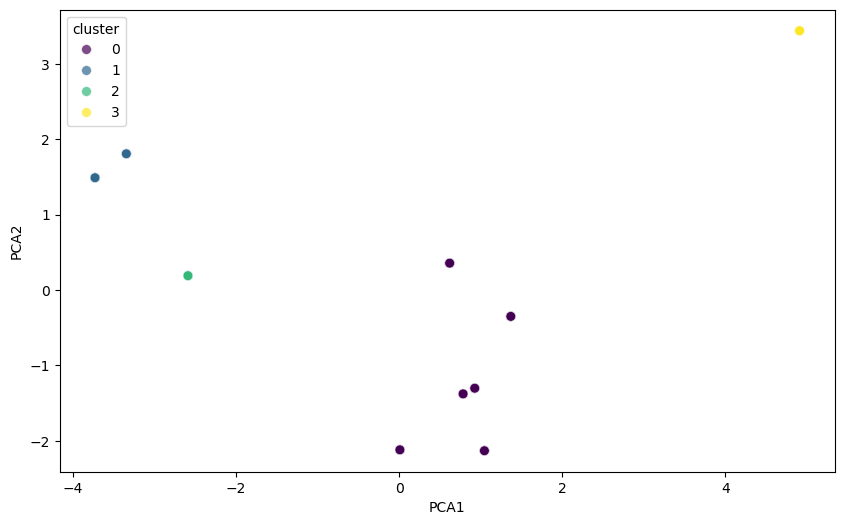

In [232]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_std)

df_std['PCA1'] = pca_result[:, 0]
df_std['PCA2'] = pca_result[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_std, x='PCA1', y='PCA2', hue='cluster', palette='viridis', s=50, alpha=0.7, edgecolor='w', linewidth=0.5)
plt.show()

## 2.5 Произведена классификация выделенных признаков


In [233]:
X_train, X_test, y_train, y_test = train_test_split(df_std[['title_char_count_n', 'theme_word_count_n', 'theme_char_count_n',
       'description_word_count_n', 'description_char_count_n']], df_std[['cluster']], test_size=0.2)

In [234]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [235]:
# Оценка модели
model.score(X_test, y_test)

0.9919775586850316

## 3. Визуальный анализ статистики текстовых признаков

## 3.1 Построена таблица с признаком и частотой встречаемости

In [236]:
# Загрузка стоп-слов для русского языка
nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))


# Функция для очистки текста и токенизации
def preprocess_text(text):
    text = text.lower()  # Приведение к нижнему регистру
    text = re.sub(r'[^\w\s]', '', text)  # Удаление знаков препинания
    words = text.split()  # Разделение текста на слова
    words = [word for word in words if word not in stop_words and not word.isdigit()]  # Удаление стоп-слов и чисел
    return words

# Обработка текстовых столбцов и вычисление частоты слов
all_words = []
for column in ['title', 'theme', 'description']:
    df[column] = df[column].astype(str)  # Убедитесь, что данные строкового типа
    for text in df[column]:
        words = preprocess_text(text)
        all_words.extend(words)

# Подсчет частоты слов
word_freq = Counter(all_words)

# Преобразование в DataFrame
word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)

# Вывод результатов
word_freq_df.head(20)  # Выводим 20 самых частотных слов

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\royti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,Word,Frequency
9,газ,207
0,россия,138
13,форум,92
60,главный,69
42,развитие,69
49,октябрь,46
120,поставка,46
47,выставка,46
58,отрасль,46
64,экономика,46


## 3.2 Построена диаграмма распределения текстовых признаков

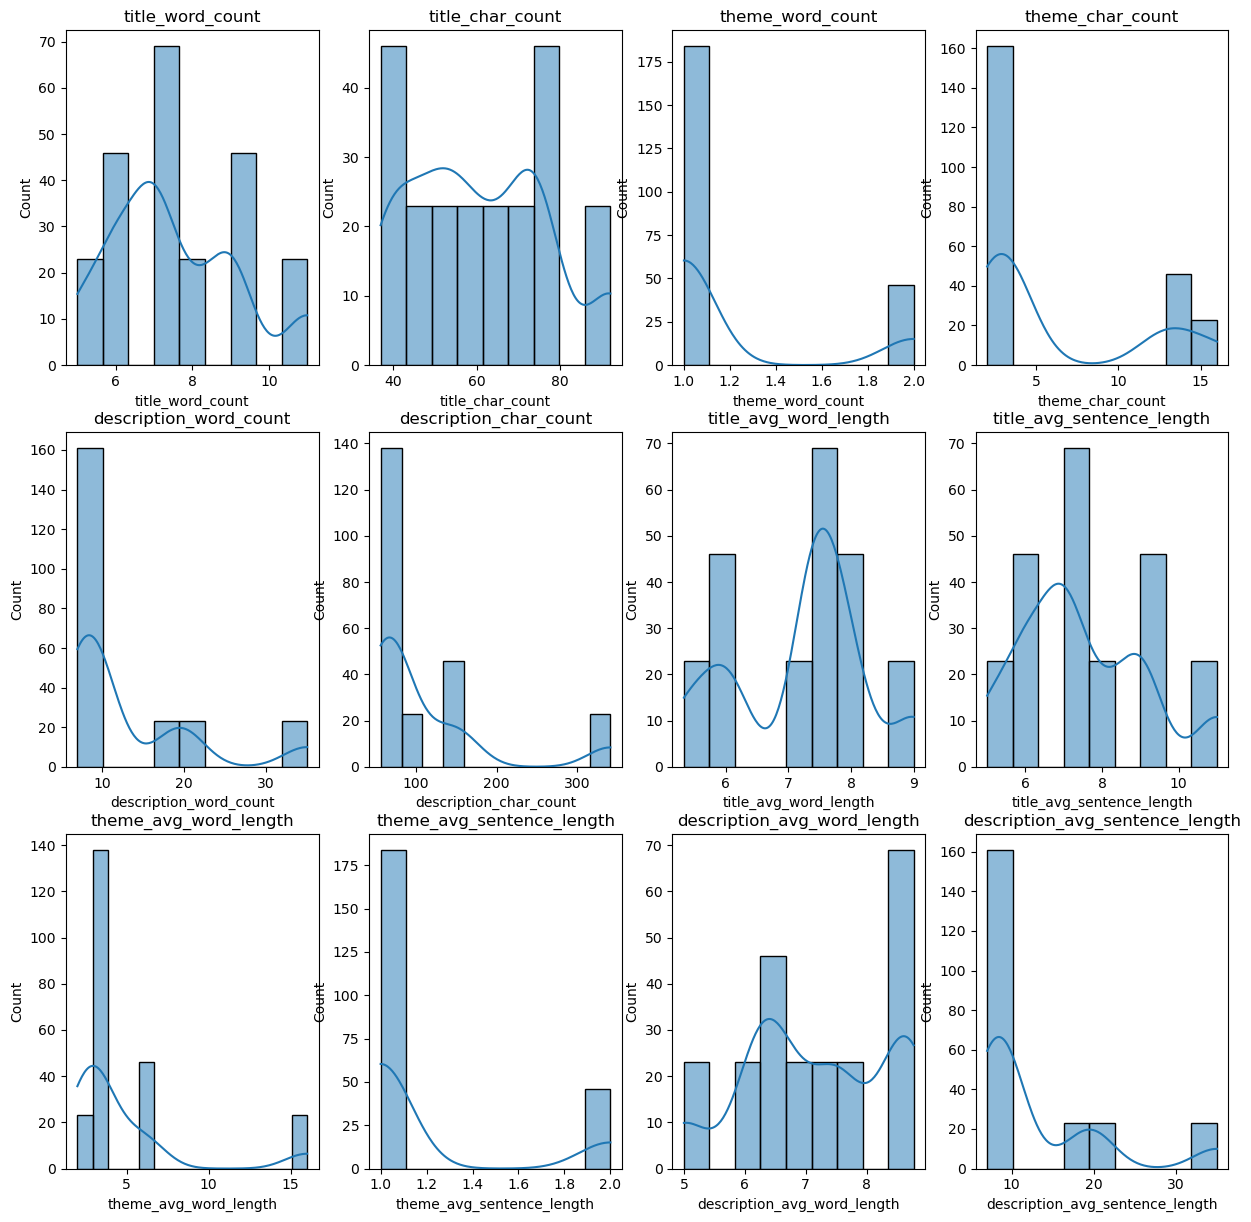

In [237]:
# Построение гистограмм для каждого признака
plt.figure(figsize=(15, 20))

df_count = df[['title_word_count',
       'title_char_count', 'theme_word_count', 'theme_char_count',
       'description_word_count', 'description_char_count',
       'title_avg_word_length', 'title_avg_sentence_length',
       'theme_avg_word_length', 'theme_avg_sentence_length',
       'description_avg_word_length', 'description_avg_sentence_length']]

count = 1
for i in df_count.columns:
    plt.subplot(4, 4, count)
    sns.histplot(df_count[i], kde=True)
    plt.title(i)
    count += 1

plt.show()